# Setup

In [15]:
%pip install requests
%pip install alpaca-py
%pip install pandas
%pip install pytz
%pip install matplotlib
%pip install numpy
%pip install scipy
%pip install tables
%pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\jrfas\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Importing Packages

In [16]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from alpaca.data.requests import StockBarsRequest
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import threading


In [ ]:
# My goal here is to grab the stock information for a single given stock over the time frame '22 to '26. I need this data to help build my threshold information. 
# I am following the guide outlined here: https://alpaca.markets/sdks/python/market_data.html
# My end goal is to sample this data to produce dollar bars
stock_client = StockHistoricalDataClient("PKNRT5QQVWLSHPPR5SAAWA6S66", "AgSmzUw1yyT4WisVWXbfb88i5Uk6WXUEaHp2r1rYLn4p")


request_params = StockBarsRequest(
                        symbol_or_symbols=["NVDA"],
                        timeframe=TimeFrame.Minute,
                        start=datetime(2022, 7, 1),
                        end=datetime(2026, 2, 5)
                 )

bars = stock_client.get_stock_bars(request_params)
bars = bars.df

# I need to figure out how to build a threshold on the trading volumn to produce about 50 bars worth of data a day based on this 1 minute time interval

# According to Advanced in Financial data mining, I want to calculate the number based on how often we think our  algorithm needs to trade or re-evaluate the market.
# The book lists 50 as a good cut off and simple "goldylocks" number, for now, lets just go with it. 

print(bars)

You need to know how much money moves through this specific stock on an average day.
• The Calculation: Sum the Close Price * Volume for every minute of a single day (or an average of the last 30 days) to get the Total Daily Dollar Volume.
    ◦ Example: If NVDA trades roughly $20 Billion per day.

Based on my current cell, I have three general lines of thought

1. I can just use every single day to calculate the threshold, so from '22 to '26 based on my data, however the trading % is going to change significantly so my threshold is unlikely to stay consistant, which leads me to idea 2
2. I can grab every 30 days and produce the threshold based on that
3. I can calculate a simple average moving threshold where the 30 day window moves right from oldest to newest and bars are generated based on this moving average 


#3 sounds the coolest and most likely to be a pain, so let's pick that one

In [ ]:
# This first creates a new field for each row called "dollar_volume"
def clean_data(bars_df):
    return bars_df.dropna(subset=["close", "volume"]).copy()


def calculate_daily_dollar_volume(bars_df):
    df = bars_df.copy()
    df["dollar_volume"] = df["close"] * df["volume"]
    daily = df.groupby(df.index.get_level_values("timestamp").date)["dollar_volume"].sum()
    return df, daily.sort_index()

def rolling_daily_threshold(daily_dv, window_days=30, bars_per_day=50):
    return daily_dv.rolling(window_days).mean() / bars_per_day

#Used AI to help me build this function, passing in the input from the above three cleaning functions, My prompt was the following:
#build_dollar_bars() function that uses daily_threshold to produce the actual ~50 bars/day.
def build_dollar_bars(bars_df, daily_threshold):
    df = bars_df.copy()
    if "dollar_volume" not in df.columns:
        df["dollar_volume"] = df["close"] * df["volume"]

    ts = df.index.get_level_values("timestamp")
    df = df.assign(date=ts.date, ts=ts)

    output = []
    
    for date, day_df in df.groupby("date"):
        threshold = daily_threshold.get(date)
        if pd.isna(threshold) or threshold <= 0:
            continue

        # Convert to numpy arrays for faster access
        opens = day_df['open'].values
        highs = day_df['high'].values
        lows = day_df['low'].values
        closes = day_df['close'].values
        volumes = day_df['volume'].values
        dollar_vols = day_df['dollar_volume'].values
        timestamps = day_df['ts'].values

        open_price = None
        high_price = None
        low_price = None
        close_price = None
        volume_sum = 0
        dollar_sum = 0
        start_ts = None
        start_idx = 0

        for i in range(len(day_df)):
            if open_price is None:
                open_price = opens[i]
                high_price = highs[i]
                low_price = lows[i]
                start_ts = timestamps[i]
                start_idx = i
                volume_sum = 0
                dollar_sum = 0

            high_price = max(high_price, highs[i])
            low_price = min(low_price, lows[i])
            close_price = closes[i]
            volume_sum += volumes[i]
            dollar_sum += dollar_vols[i]

            if dollar_sum >= threshold:
                output.append({
                    "date": date,
                    "start_ts": start_ts,
                    "end_ts": timestamps[i],
                    "open": open_price,
                    "high": high_price,
                    "low": low_price,
                    "close": close_price,
                    "volume": volume_sum,
                    "dollar_volume": dollar_sum,
                    "threshold": threshold,
                })
                open_price = None

        # Flush incomplete bar
        if open_price is not None:
            output.append({
                "date": date,
                "start_ts": start_ts,
                "end_ts": timestamps[-1],
                "open": open_price,
                "high": high_price,
                "low": low_price,
                "close": close_price,
                "volume": volume_sum,
                "dollar_volume": dollar_sum,
                "threshold": threshold,
            })

    return pd.DataFrame(output)

raw_bars = bars
bars = clean_data(bars)
bars, daily_dv = calculate_daily_dollar_volume(bars)
daily_threshold = rolling_daily_threshold(daily_dv, window_days=30, bars_per_day=50)
dollar_bars = build_dollar_bars(bars, daily_threshold)

dollar_bars.head()


,date,start_ts,end_ts,open,high,low,close,volume,dollar_volume,threshold
0,2022-08-12,2022-08-12 08:00:00,2022-08-12 13:31:00,180.0700,181.9900,178.9720,180.46,1066647.0,1.929144e+08,1.868424e+08
1,2022-08-12,2022-08-12 13:32:00,2022-08-12 13:36:00,180.4200,180.8500,179.5300,180.12,1235144.0,2.223000e+08,1.868424e+08
2,2022-08-12,2022-08-12 13:37:00,2022-08-12 13:40:00,180.1700,182.3300,180.1177,182.25,1184260.0,2.148436e+08,1.868424e+08
3,2022-08-12,2022-08-12 13:41:00,2022-08-12 13:45:00,182.3178,182.9221,181.8800,182.80,1130959.0,2.065129e+08,1.868424e+08
4,2022-08-12,2022-08-12 13:46:00,2022-08-12 13:49:00,182.7900,183.3300,181.9600,182.24,1147869.0,2.096406e+08,1.868424e+08


# Validation

Yay, we generated dollar bars! Our next step is to say: well, are they any good?

To do this, the book reccomends 4 general tests

1. Stability testing
   1. count the number of bars produces on a weekly basis over a long time period. If done correctly, we hope it is generally stable
2. Serial Correlation
   1. Machine learning algorithms generally assume observations are independent and identically distributed. Time bars exhibit high serial correlation(todays return preducts tommorows return) which breaks this assumption. We need to test the autocorrelation of our new dollar bars.  We hope that it's LOWER and our sampling has broken up the market noise
3. Heteroskedasticity Test
   1. Time Bars often suffer volatility chantes dastically throughout the day (open, lunch, close: different trading volume) We can split our data into monthly subsets to calcualte variance of returns for each month, we expect this to be smaller than our raw data
4. Jarque-Bera
   1. we want to try to create a normal distribution of bars, we hope that our dollar bars create a bell curve. This is important as most statistical methods rely on the assumption that observations are drawn from a gaussian process.
   

1) Stability test (weekly counts):
Period: 2022-08-14 -> 2026-02-08
Weeks: 183, mean bars/week: 222.86, std: 57.38
count    183.000000
mean     222.857923
std       57.380181
min       43.000000
25%      188.000000
50%      217.000000
75%      250.500000
max      505.000000
dtype: float64


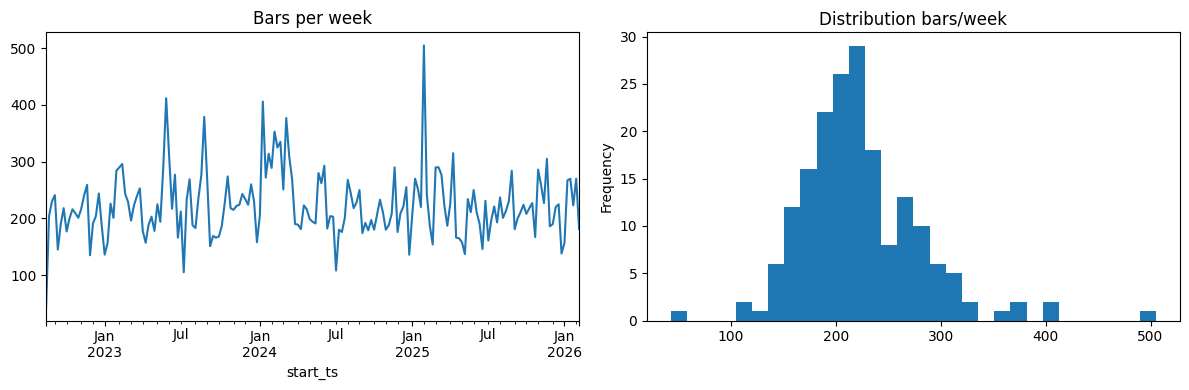


2) Serial correlation test (log returns):
Lag-1 autocorr: -0.0109


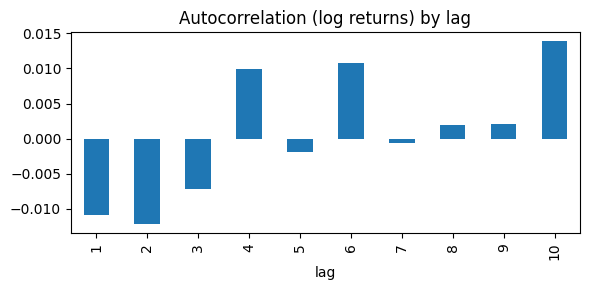


3) Heteroskedasticity test (monthly variances):
Return variance by period (sample):
count    43.000000
mean      0.000017
std       0.000010
min       0.000005
25%       0.000010
50%       0.000016
75%       0.000020
max       0.000055
Name: log_ret, dtype: float64
Levene test p-value (equal variances): 0.0000


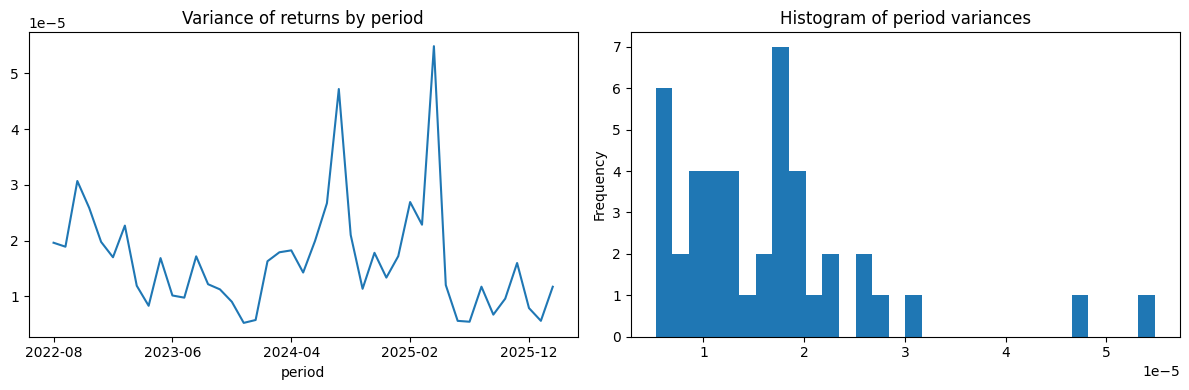


4) Jarque-Bera normality test:
JB stat: 774472.3281, p-value: 0.0, skew: 0.0539, excess kurtosis: 21.5980


In [ ]:
try:
    from scipy.stats import jarque_bera, levene
except Exception:
    jarque_bera = None
    levene = None

def _ensure_returns(df, price_col="close", ret_col="log_ret", reset_daily=True):
    """
    Ensure 'start_ts' is datetime and compute log returns.

    If reset_daily=True, compute log returns within each trading day (no overnight jumps).
    Otherwise compute across the whole series (may include overnight gaps).
    """
    df = df.copy()
    df["start_ts"] = pd.to_datetime(df["start_ts"])
    if ret_col not in df.columns:
        if reset_daily:
            df["date"] = df["start_ts"].dt.date
            # compute log returns per-day to avoid overnight jumps
            df[ret_col] = df.groupby("date")[price_col].transform(lambda x: np.log(pd.to_numeric(x)).diff())
        else:
            df[ret_col] = np.log(pd.to_numeric(df[price_col])).diff()
    return df

def stability_test(df, date_col="start_ts", freq="W", plot=True):
    """
    Count bars on a weekly basis and report stability statistics.
    Returns a Series indexed by week -> bar counts.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    s = df.set_index(date_col).resample(freq).size()
    print(f"Period: {s.index.min().date()} -> {s.index.max().date()}")
    print(f"Weeks: {len(s)}, mean bars/week: {s.mean():.2f}, std: {s.std():.2f}")
    print(s.describe())
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        s.plot(ax=ax[0], title="Bars per week")
        s.plot(kind="hist", ax=ax[1], bins=30, title="Distribution bars/week")
        plt.tight_layout()
        plt.show()
    return s

def serial_correlation_test(df, price_col="close", ret_col="log_ret", max_lag=10, plot=True, reset_daily=True):
    """
    Compute autocorrelations of log-returns up to max_lag.
    Returns a Series of autocorrelations.
    """
    df = _ensure_returns(df, price_col=price_col, ret_col=ret_col, reset_daily=reset_daily)
    rets = df[ret_col].dropna()
    if rets.empty:
        print("No returns to compute autocorrelation.")
        return pd.Series(dtype=float)
    acfs = {lag: rets.autocorr(lag=lag) for lag in range(1, max_lag+1)}
    acf_ser = pd.Series(acfs)
    if not acf_ser.empty:
        print(f"Lag-1 autocorr: {acf_ser.iloc[0]:.4f}")
    if plot and not acf_ser.empty:
        fig, ax = plt.subplots(figsize=(6,3))
        acf_ser.plot.bar(ax=ax, title="Autocorrelation (log returns) by lag")
        ax.set_xlabel("lag")
        plt.tight_layout()
        plt.show()
    return acf_ser

def heteroskedasticity_test(df, price_col="close", ret_col="log_ret", period="M", plot=True, reset_daily=True):
    """
    Split returns by periods (monthly by default), compute variance per period,
    and perform Levene test (if available) to check equality of variances.
    Returns (var_series, levene_pvalue)
    """
    df = _ensure_returns(df, price_col=price_col, ret_col=ret_col, reset_daily=reset_daily)
    df["period"] = pd.to_datetime(df["start_ts"]).dt.to_period(period).astype(str)
    groups = df.dropna(subset=[ret_col]).groupby("period")[ret_col].apply(list)
    # use sample variance (ddof=1) for each group if group size >1
    def _var(lst):
        arr = np.asarray(lst)
        if arr.size <= 1:
            return np.nan
        return np.var(arr, ddof=1)
    var_ser = groups.apply(_var)
    print("Return variance by period (sample):")
    print(var_ser.describe())
    pval = None
    if levene is not None and len(groups) >= 2:
        try:
            # Levene requires arrays, skip groups with <2 observations
            arrays = [np.asarray(g) for g in groups.values if len(g) >= 2]
            if len(arrays) >= 2:
                stat, pval = levene(*arrays)
                print(f"Levene test p-value (equal variances): {pval:.4f}")
            else:
                print("Not enough groups with >=2 observations for Levene test.")
        except Exception:
            pval = None
    else:
        print("scipy.levene not available or not enough groups; skipping Levene test.")
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        var_ser.plot(ax=ax[0], title="Variance of returns by period")
        var_ser.plot(kind="hist", ax=ax[1], bins=30, title="Histogram of period variances")
        plt.tight_layout()
        plt.show()
    return var_ser, pval

def jarque_bera_test(df, price_col="close", ret_col="log_ret", reset_daily=True):
    """
    Run Jarque-Bera normality test on log-returns.
    Returns dict with statistic, pvalue, skew, kurtosis.
    """
    df = _ensure_returns(df, price_col=price_col, ret_col=ret_col, reset_daily=reset_daily)
    rets = df[ret_col].dropna()
    n = rets.shape[0]
    if n == 0:
        return {"n": 0, "jb_stat": None, "pvalue": None, "skew": None, "excess_kurtosis": None}
    skew = rets.skew()
    kurt = rets.kurt()  # excess kurtosis by pandas
    if jarque_bera is not None:
        try:
            jb_stat, jb_p = jarque_bera(rets)
        except Exception:
            jb_stat = None
            jb_p = None
    else:
        jb_stat = n/6.0 * (skew**2 + (kurt**2)/4.0)
        jb_p = None
    print(f"JB stat: {jb_stat:.4f}, p-value: {jb_p}, skew: {skew:.4f}, excess kurtosis: {kurt:.4f}")
    return {"n": n, "jb_stat": jb_stat, "pvalue": jb_p, "skew": skew, "excess_kurtosis": kurt}

def validate_all(df, target_per_day=50, reset_daily=True):
    """
    Run the four validation steps and return a dict of results.
    reset_daily controls whether returns are computed within each trading day (recommended).
    """
    print("1) Stability test (weekly counts):")
    stability = stability_test(df, freq="W", plot=True)
    print("\n2) Serial correlation test (log returns):")
    acf = serial_correlation_test(df, max_lag=10, plot=True, reset_daily=reset_daily)
    print("\n3) Heteroskedasticity test (monthly variances):")
    var_ser, levene_p = heteroskedasticity_test(df, period="M", plot=True, reset_daily=reset_daily)
    print("\n4) Jarque-Bera normality test:")
    jb = jarque_bera_test(df, reset_daily=reset_daily)
    return {
        "stability_weekly": stability,
        "autocorr": acf,
        "period_variance": var_ser,
        "levene_pvalue": levene_p,
        "jarque_bera": jb
    }
results = validate_all(dollar_bars, target_per_day=50, reset_daily=True)

# Retesting

My Validation steps didn't work.... my distribution looks nothing like the curve I want, so we try again. I average about 45 bars instead of closer to 50. It's at this point that I refered to the online documentation and google.

count    9.560000e+02
mean     2.491523e+10
std      1.545971e+10
min      6.409324e+05
25%      1.162473e+10
50%      2.452218e+10
75%      3.399056e+10
max      1.039596e+11
Name: dollar_volume, dtype: float64
2022-07-01   NaN
2022-07-05   NaN
2022-07-06   NaN
2022-07-07   NaN
2022-07-08   NaN
2022-07-11   NaN
2022-07-12   NaN
2022-07-13   NaN
2022-07-14   NaN
2022-07-15   NaN
Name: dollar_volume, dtype: float64
count    927.000000
mean      43.994606
std       17.603596
min        1.000000
25%       36.000000
50%       42.000000
75%       52.000000
max      164.000000
dtype: float64
1) Stability test (weekly counts):
Period: 2022-07-10 -> 2026-02-08
Weeks: 188, mean bars/week: 251.87, std: 62.91
count    188.000000
mean     251.867021
std       62.910329
min      124.000000
25%      212.500000
50%      244.000000
75%      281.500000
max      541.000000
dtype: float64


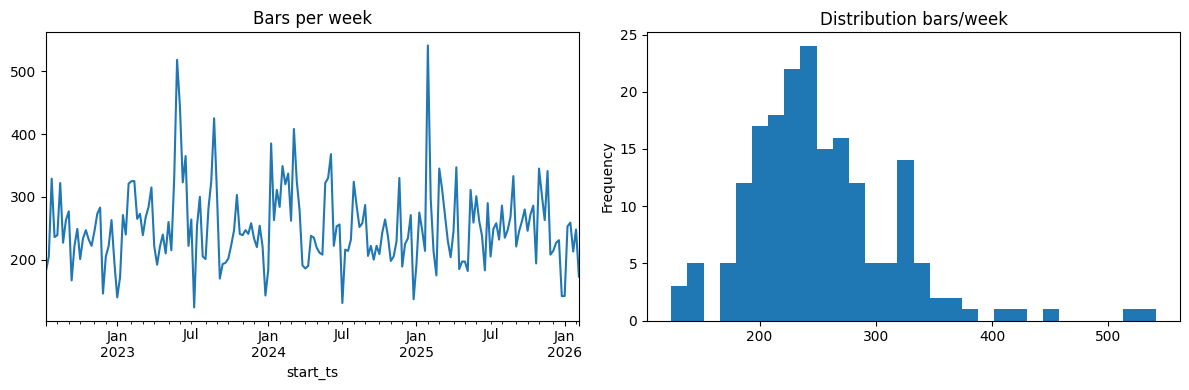


2) Serial correlation test (log returns):
Lag-1 autocorr: -0.0124


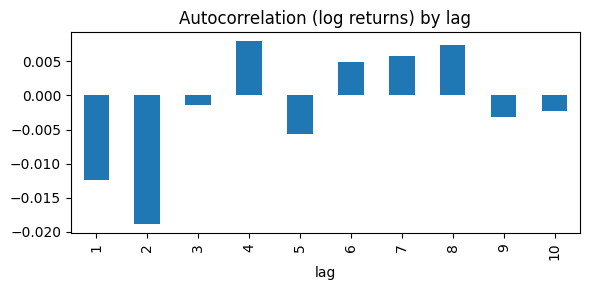


3) Heteroskedasticity test (monthly variances):
Return variance by period (sample):
count    44.000000
mean      0.000015
std       0.000009
min       0.000004
25%       0.000009
50%       0.000014
75%       0.000017
max       0.000048
Name: log_ret, dtype: float64
Levene test p-value (equal variances): 0.0000


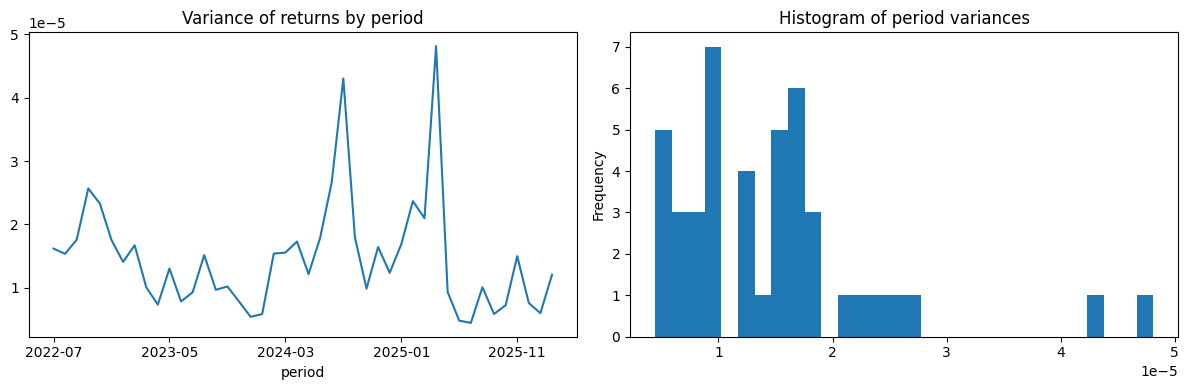


4) Jarque-Bera normality test:
JB stat: 826895.1261, p-value: 0.0, skew: -0.0660, excess kurtosis: 20.6718


In [ ]:

def calculate_daily_dollar_volume(bars_df, ts_level="timestamp", tz="US/Eastern"):
    df = bars_df.copy()
    ts = pd.to_datetime(df.index.get_level_values(ts_level))
    if ts.tz is None:
        ts = ts.tz_localize("UTC").tz_convert(tz)
    else:
        ts = ts.tz_convert(tz)
    df = df.assign(_ts=ts)

    # filter Regular Trading Hours 09:30 - 16:00 (ET)
    start = pd.to_datetime("09:30").time()
    end = pd.to_datetime("16:00").time()
    rth_mask = (df["_ts"].dt.time >= start) & (df["_ts"].dt.time < end)
    rth = df.loc[rth_mask].copy()

    # compute dollar volume from RTH data for daily totals
    rth["dollar_volume"] = rth["close"] * rth["volume"]
    daily = rth.groupby(rth["_ts"].dt.date)["dollar_volume"].sum()
    daily.index = pd.Index([pd.to_datetime(d).date() for d in daily.index], name="date")

    df["dollar_volume"] = df["close"] * df["volume"]
    return df.drop(columns=["_ts"]), daily.sort_index()


def rolling_daily_threshold(daily_dv, window_days=30, bars_per_day=50):

    roll = daily_dv.rolling(window=window_days, min_periods=1).median() / bars_per_day
    roll.index = pd.Index([pd.to_datetime(i).date() for i in roll.index], name="date")
    # shift by 1 day: use yesterday's value as today's threshold (no lookahead)
    return roll.shift(1)

# I once again used AI to help me build this function, passing in the input from the above three cleaning functions, My prompt was the following:
#build_dollar_bars() function that uses daily_threshold to produce the actual ~50 bars/day.
def build_dollar_bars(bars_df, daily_threshold, ts_level="timestamp", tz="US/Eastern", drop_incomplete_last_bar=True):
    df = bars_df.copy()
    if "dollar_volume" not in df.columns:
        df["dollar_volume"] = df["close"] * df["volume"]

    ts = pd.to_datetime(df.index.get_level_values(ts_level))
    if ts.tz is None:
        ts = ts.tz_localize("UTC").tz_convert(tz)
    else:
        ts = ts.tz_convert(tz)
    df = df.assign(date=ts.date, ts=ts)

    th_map = {pd.to_datetime(k).date(): v for k, v in daily_threshold.items()}

    output = []
    for date, day_df in df.groupby("date"):
        threshold = th_map.get(date)
        if threshold is None or pd.isna(threshold) or threshold <= 0:
            continue

        opens = day_df["open"].values
        highs = day_df["high"].values
        lows = day_df["low"].values
        closes = day_df["close"].values
        volumes = day_df["volume"].values
        dollar_vols = day_df["dollar_volume"].values
        timestamps = day_df["ts"].values

        open_price = None
        high_price = None
        low_price = None
        close_price = None
        volume_sum = 0.0
        dollar_sum = 0.0
        start_ts = None

        for i in range(len(day_df)):
            if open_price is None:
                open_price = opens[i]
                high_price = highs[i]
                low_price = lows[i]
                start_ts = timestamps[i]
                volume_sum = 0.0
                dollar_sum = 0.0

            # Snapshot prior totals before this minute
            prev_dollar = dollar_sum
            prev_volume = volume_sum

            # Add current minute
            high_price = max(high_price, highs[i])
            low_price = min(low_price, lows[i])
            close_price = closes[i]
            minute_dollar = float(dollar_vols[i])
            minute_volume = float(volumes[i])

            dollar_sum = prev_dollar + minute_dollar
            volume_sum = prev_volume + minute_volume

            if dollar_sum >= threshold:
                # Fill the remainder of the current bar using part of this minute
                needed = threshold - prev_dollar
                if minute_dollar <= 0:
                    continue

                fill_ratio = needed / minute_dollar
                fill_volume = minute_volume * fill_ratio

                output.append({
                    "date": date,
                    "start_ts": start_ts,
                    "end_ts": timestamps[i],
                    "open": open_price,
                    "high": high_price,
                    "low": low_price,
                    "close": close_price,
                    "volume": prev_volume + fill_volume,
                    "dollar_volume": threshold,
                    "threshold": threshold,
                })

                # Remaining part of this minute after finishing the bar
                rem_dollar = minute_dollar - needed
                rem_volume = minute_volume - fill_volume

                # Create as many full bars as possible from the remaining part of this minute
                while rem_dollar >= threshold and rem_dollar > 0:
                    ratio = rem_volume / rem_dollar if rem_dollar > 0 else 0.0
                    output.append({
                        "date": date,
                        "start_ts": timestamps[i],
                        "end_ts": timestamps[i],
                        "open": close_price,
                        "high": highs[i],
                        "low": lows[i],
                        "close": close_price,
                        "volume": threshold * ratio,
                        "dollar_volume": threshold,
                        "threshold": threshold,
                    })
                    rem_dollar -= threshold
                    rem_volume = rem_volume - (threshold * ratio)

                # Carry remainder to the next bar
                if rem_dollar > 0:
                    dollar_sum = rem_dollar
                    volume_sum = rem_volume
                    open_price = close_price
                    high_price = highs[i]
                    low_price = lows[i]
                    start_ts = timestamps[i]
                else:
                    open_price = None  # start next bar

        # Drop incomplete last bar (avoid appending partial bar)
        if not drop_incomplete_last_bar:
            if open_price is not None:
                output.append({
                    "date": date,
                    "start_ts": start_ts,
                    "end_ts": timestamps[-1],
                    "open": open_price,
                    "high": high_price,
                    "low": low_price,
                    "close": close_price,
                    "volume": volume_sum,
                    "dollar_volume": dollar_sum,
                    "threshold": threshold,
                })

    return pd.DataFrame(output)

bars_clean = clean_data(raw_bars)
bars_with_dv, daily_dv_new = calculate_daily_dollar_volume(bars_clean)  # uses RTH filter
daily_threshold_new = rolling_daily_threshold(daily_dv_new, window_days=30, bars_per_day=50)
dollar_bars_new = build_dollar_bars(bars_with_dv, daily_threshold_new)

print(daily_dv.describe())
print(daily_threshold.head(10))
print(dollar_bars.groupby('date').size().describe())
results_new = validate_all(dollar_bars_new, target_per_day=50, reset_daily=True)

=== OLD PIPELINE ===
count    927.000000
mean      43.994606
std       17.603596
min        1.000000
25%       36.000000
50%       42.000000
75%       52.000000
max      164.000000
dtype: float64

=== NEW PIPELINE (RTH + median + shift) ===
count    901.000000
mean      52.553829
std       16.403815
min       18.000000
25%       42.000000
50%       49.000000
75%       59.000000
max      202.000000
dtype: float64


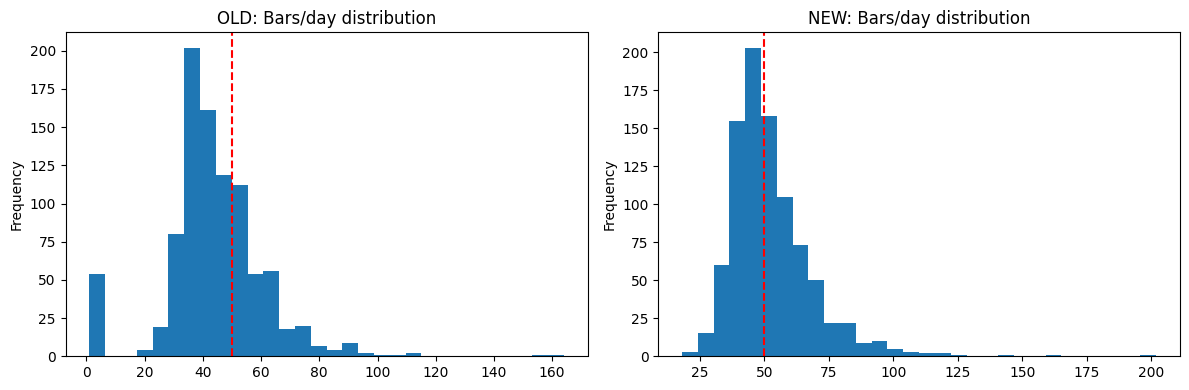


OLD: Days within 40-60 bars: 48.1%
NEW: Days within 40-60 bars: 62.3%


In [ ]:
# Compare OLD vs NEW side-by-side
print("=== OLD PIPELINE ===")
bars_per_day_old = dollar_bars.groupby('date').size()
print(bars_per_day_old.describe())

print("\n=== NEW PIPELINE (RTH + median + shift) ===")
bars_per_day_new = dollar_bars_new.groupby('date').size()
print(bars_per_day_new.describe())


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
bars_per_day_old.plot(kind='hist', ax=axes[0], bins=30, title='OLD: Bars/day distribution')
bars_per_day_new.plot(kind='hist', ax=axes[1], bins=30, title='NEW: Bars/day distribution')
axes[0].axvline(50, color='red', linestyle='--', label='target=50')
axes[1].axvline(50, color='red', linestyle='--', label='target=50')
plt.tight_layout()
plt.show()


print(f"\nOLD: Days within 40-60 bars: {((bars_per_day_old >= 40) & (bars_per_day_old <= 60)).mean()*100:.1f}%")
print(f"NEW: Days within 40-60 bars: {((bars_per_day_new >= 40) & (bars_per_day_new <= 60)).mean()*100:.1f}%")

# Dang!

This is pretty darn good and for NVDA, looks great!

Now, my above python functions might have looked a bit overly verbose and goofy. Especially the cleaning functions, but I did this in the hope that I could **generalize**. Now that I have the pipeline working, my next step is to run it on **multiple** stock tickers to build my dataset for not only nvda, but for as many stocks as possible to create my dataset.

The large question I also need to answer is, how on earth do I store it? 

In our chapter 2 section from Jansen

We have four realistic choices outlined in our course text:
1. csv
2. sql
3. HDF5
4. Parquet


I was between HD and Parquet. As we are going to do machine learning, I think im going to stick with HDF5 as I saw online that it plays nicer with Pytorch/Tenserflow. The book uses a hybrid approach noting that parquete is great for mixed numerical and text data...so I might reformat as needed in the future

So, my next step is to convert the dataframe into HDF5 format and generate the file

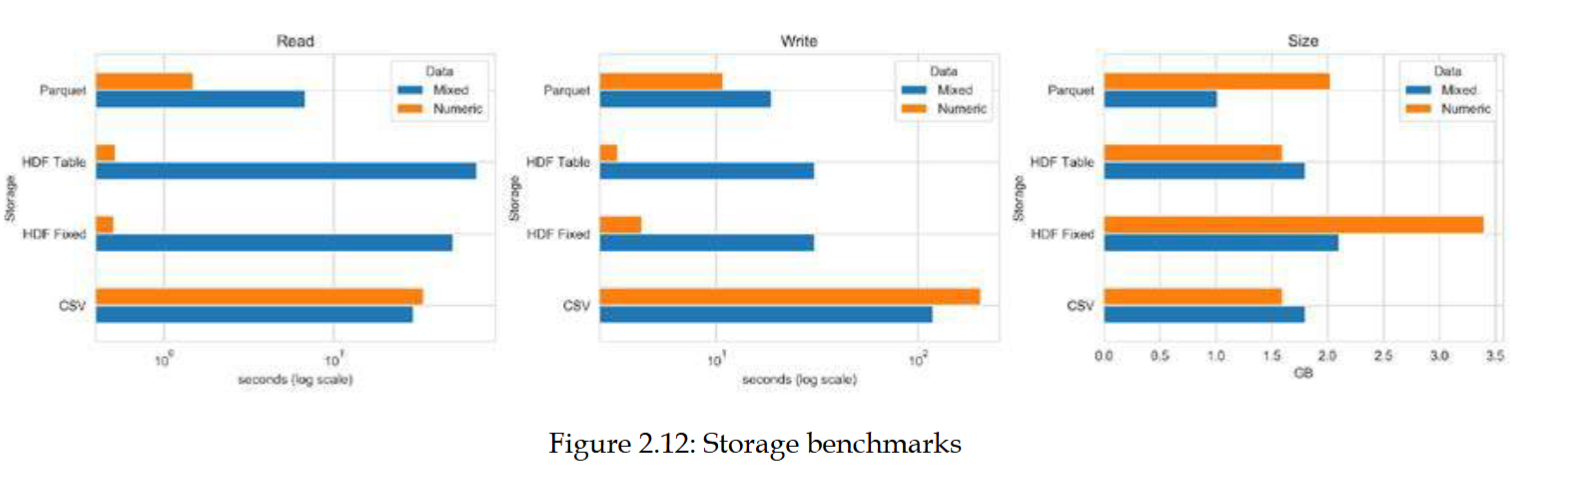

In [ ]:
# You can find documentation for this step here
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_hdf.html

# I think this worked?
dollar_bars_new.to_hdf("nvda_dollar_bars.h5", key="dollar_bars", mode="w")

C:\Users\jrfas\AppData\Local\Temp\ipykernel_34520\3532410215.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->date,key->block0_values] [items->Index(['date'], dtype='object')]

  dollar_bars_new.to_hdf("nvda_dollar_bars.h5", key="dollar_bars", mode="w")


# Finding the best data to pull

Jansen notes that it's a bad idea to simply pull **all** the possible stock. If we exclude stocks with low volume, we reduce noise and overall training time. Furthermore, downloading the whole raw data introduces survivorship bias(you ignore companies that go bankrupt) which ruins backtest validity

so, we want to do the following

1. Download all the daily volumn and price for all tickers in just the last 30 days
2. calculate the average daily dollar volumn
3. keep only the top 1000 tickers
4. The result is our master ticket list

Alpaca has the master list of assets, this information can be found here
https://docs.alpaca.markets/reference/get-v2-assets-1



In [ ]:
from alpaca.broker import client
from alpaca.trading.requests import GetAssetsRequest

#Note: I learned only AFTER writing this, you need seperate api keys for the broker client
# Get those here: https://broker-app.alpaca.markets/dashboard

broker_client = client.BrokerClient("CKLT25NW36HKISSIU2C2FIZYD2", "2eoL9ssEDZCokCmWdg1HzHKzEMCXkpYxb7jHfteooo6c")

request_params = GetAssetsRequest(
    status="active",
    asset_class="us_equity",
    exchange="NYSE"
)

nyse_assets = broker_client.get_all_assets(request_params)
nasdaq_assets = broker_client.get_all_assets(GetAssetsRequest(status="active", asset_class="us_equity", exchange="NASDAQ"))

print(f"Active NYSE assets: {len(nyse_assets)}")
print(f"Active NASDAQ assets: {len(nasdaq_assets)}")




Active NYSE assets: 2881
Active NASDAQ assets: 5331


In [ ]:

def fetch_symbols_from_response(nyse_assets, nasdaq_assets):
    #This is called list comprehension
    nyse_symbols = [asset.symbol for asset in nyse_assets if asset.status == "active" and asset.tradable]
    nasdaq_symbols = [asset.symbol for asset in nasdaq_assets if asset.status == "active" and asset.tradable]
    return nyse_symbols + nasdaq_symbols
symbols_list = fetch_symbols_from_response(nyse_assets, nasdaq_assets)
print(len(symbols_list), "Count of symbols fetched from broker API")


8158 Count of symbols fetched from broker API


In [ ]:
def find_top_1000_assets(symbols_list, stock_client):
    # This function will fetch the latest daily dollar volume for each symbol and return the top 1000 by that metric.
    bars = stock_client.get_stock_bars(StockBarsRequest(
        symbol_or_symbols=symbols_list,
        timeframe=TimeFrame.Day,
        start=datetime(2026, 1, 1),
        end=datetime(2026, 2, 1)
    ))
    bars_df = bars.df
    bars_df["dollar_volume"] = bars_df["close"] * bars_df["volume"]
    # Sort symbols by dollar volume and take top 1000
    top_1000 = bars_df.groupby("symbol")["dollar_volume"].sum().nlargest(1000)
    return top_1000

top_1000_symbols = find_top_1000_assets(symbols_list, stock_client)
print("Top 1000 symbols by latest daily dollar volume:")
print(top_1000_symbols)




Top 1000 symbols by latest daily dollar volume:
symbol
QQQ     6.746866e+11
NVDA    6.141162e+11
TSLA    5.567444e+11
MSFT    3.134278e+11
MU      2.781284e+11
            ...     
CRWG    2.200888e+09
FBIN    2.197632e+09
ALC     2.195588e+09
ZION    2.194076e+09
EXEL    2.192365e+09
Name: dollar_volume, Length: 1000, dtype: float64


# Pulling and Shaping Large Amounts of Data

Our next step here is, given the 1000 most traded assets, performing the same calculations we did above, for each one, then saving the file. 

our nvda chart was 5081064 bits, which is about 5mb. so all this together should come out to about 5000 MB, or 5GB worth of data, owch.  

I also am going to swap to using parquet because everwhere I see online keeps yelling at me to use it. So I give in.

In [ ]:
def bars_info_builder(stock, bars):
        try:
                raw_bars = bars
                bars_clean = clean_data(raw_bars)
                bars_with_dv, daily_dv_new = calculate_daily_dollar_volume(bars_clean)  # uses RTH filter
                daily_threshold_new = rolling_daily_threshold(daily_dv_new, window_days=30, bars_per_day=50)
                dollar_bars_new = build_dollar_bars(bars_with_dv, daily_threshold_new)
                if dollar_bars_new.empty:
                        print(f"  Skipping {stock}: no dollar bars generated")
                        return 
                # Add symbol column
                dollar_bars_new["symbol"] = stock
                
                # Save to parquet - each symbol gets its own file
                dollar_bars_new.to_parquet(f"dollar_bars_parquet/{stock}.parquet", index=False)
                
                print(f"  ✓ Saved {len(dollar_bars_new)} bars")
        except Exception as exc:
                print(f"  Error processing {stock}: {exc}")


def get_1000_asset_minute_bars(assetList):
        bars = stock_client.get_stock_bars(StockBarsRequest(
                symbol_or_symbols=assetList, 
                timeframe=TimeFrame.Minute, 
                start=datetime(2022, 1, 1),  
                end=datetime(2026, 2, 1)
                ))
        threads = []
        for symbol, df_sym in bars.df.groupby(level="symbol"):
                thread = threading.Thread(target=bars_info_builder, args=(symbol,df_sym))
                threads.append(thread)
                thread.start()
        for thread in threads:
               thread.join()
        

def chunks(seq, size):
    for i in range(0, len(seq), size):
        yield seq[i:i+size]
      
symbols = list(top_1000_symbols.index)
for batch in chunks(symbols, 7):
      get_1000_asset_minute_bars(batch)


  ✓ Saved 51629 bars
  ✓ Saved 52427 bars
  ✓ Saved 51092 bars
  ✓ Saved 54269 bars
  ✓ Saved 51915 bars
  ✓ Saved 52954 bars
  ✓ Saved 53749 bars
  ✓ Saved 17088 bars
  ✓ Saved 51660 bars
  ✓ Saved 51956 bars
  ✓ Saved 55274 bars
  ✓ Saved 52621 bars
  ✓ Saved 52924 bars
  ✓ Saved 53557 bars
  ✓ Saved 55504 bars
  ✓ Saved 50586 bars
  ✓ Saved 51886 bars
  ✓ Saved 51109 bars
  ✓ Saved 51238 bars
  ✓ Saved 57058 bars
  ✓ Saved 54774 bars
  ✓ Saved 49212 bars
  ✓ Saved 54685 bars
  ✓ Saved 51891 bars
  ✓ Saved 49638 bars
  ✓ Saved 50699 bars
  ✓ Saved 52456 bars
  ✓ Saved 55356 bars


KeyboardInterrupt: 